In [1]:
%load_ext lab_black
import os, sys

%load_ext autoreload
%autoreload 2

sys.path.append("/n/home12/khou/holystore/")

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import paper_utils
import matplotlib.pyplot as plt
import scTRS.data_loader as dl
import pandas as pd
import numpy as np
import scanpy as sc
from os.path import join
from statsmodels.stats.multitest import multipletests
from scipy.stats import rankdata
from tqdm import tqdm
from scipy import stats
from matplotlib.patches import Rectangle

In [2]:
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data"

dict_dset = {
    "tms_facs": join(
        DATA_PATH, "tabula_muris_senis/tabula-muris-senis-facs-official-raw-obj.h5ad"
    ),
    "tms_droplet": join(
        DATA_PATH, "tabula_muris_senis/tabula-muris-senis-droplet-official-raw-obj.h5ad"
    ),
    "ts_facs": join(
        DATA_PATH, "single_cell_data/tabula_sapiens/obj_smartseq2_raw.h5ad"
    ),
}

dict_df_obs = {k: sc.read_h5ad(dict_dset[k]).obs for k in dict_dset}

In [3]:
URL_SUPP_TABLE = "./supp_tables.xlsx"

df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name="ST1. Trait info",
)

dict_df_celltype_info = {
    "ts_facs": pd.read_excel(URL_SUPP_TABLE, sheet_name="ST5. TS FACS info"),
    "tms_facs": pd.read_excel(URL_SUPP_TABLE, sheet_name="ST3. TMS FACS info"),
    "tms_droplet": pd.read_excel(URL_SUPP_TABLE, sheet_name="ST4. TMS droplet info"),
}

for dset in ["ts_facs", "tms_droplet"]:
    dict_df_celltype_info[dset] = dict_df_celltype_info[dset].dropna(axis=0, how="all")
    dict_df_celltype_info[dset]["category"].fillna(method="ffill", inplace=True)

In [4]:
dict_fdr_prop = {
    dset: pd.read_csv(f"data/summary_ct/drs_fdr_prop.{dset}.csv", index_col=0)
    for dset in ["tms_facs", "ts_facs", "tms_droplet"]
}
dict_ct_assoc = {
    dset: pd.read_csv(f"data/summary_ct/df_pval.{dset}.csv", index_col=0)
    for dset in ["tms_facs", "ts_facs", "tms_droplet"]
}
dict_gearysc = {
    dset: pd.read_csv(f"data/summary_ct/df_gearysc_fdr.{dset}.csv", index_col=0)
    for dset in ["tms_facs", "ts_facs", "tms_droplet"]
}

# Export these raw data to excel

In [5]:
from functools import reduce

with pd.ExcelWriter("results/numeric_supp_tables.xlsx") as writer:

    for dset in ["tms_facs", "ts_facs", "tms_droplet"]:
        df1, df2, df3 = dict_fdr_prop[dset], dict_ct_assoc[dset], dict_gearysc[dset]
        print(df1.shape, df2.shape, df3.shape)
        df2 = pd.DataFrame(
            multipletests(df2.values.flatten(), method="fdr_bh")[1].reshape(df2.shape),
            index=df2.index,
            columns=df2.columns,
        )
        df1 = df1.loc[df3.index, df3.columns]
        df2 = df2.loc[df3.index, df3.columns]
        df1 = df1.melt(ignore_index=False).reset_index()
        df2 = df2.melt(ignore_index=False).reset_index()
        df3 = df3.melt(ignore_index=False).reset_index()
        df = reduce(
            lambda left, right: pd.merge(
                left, right, on=["index", "variable"], how="outer"
            ),
            [df1, df2, df3],
        )

        df.columns = [
            "trait",
            "cell-type",
            "prop-sig-cells",
            "ct-assoc-fdr",
            "heterogeneity-fdr",
        ]
        df.to_excel(writer, sheet_name=dset, float_format="%.2g", index=False)

        worksheet = writer.sheets[dset]  # pull worksheet object
        for idx, col in enumerate(df):  # loop through all columns
            series = df[col]
            max_len = (
                max(
                    (
                        series.astype(str).map(len).max(),  # len of largest item
                        len(str(series.name)),  # len of column name/header
                    )
                )
                + 1
            )  # adding a little extra space
            worksheet.set_column(idx, idx, max_len)  # set column width

(74, 120) (74, 120) (74, 120)
(74, 132) (74, 132) (74, 114)
(74, 123) (74, 123) (74, 122)


In [6]:
df_tmp = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name="fig3-display",
).dropna(how="all")

plot_order = dict()
for c, group in df_tmp.groupby("cluster"):
    plot_order[c] = (group.trait.dropna().values, group.celltype.dropna().values)

dict_trait_name = {
    row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
}


def trait_display_name(x):
    dict_trait_name = {
        row.Trait_Identifier: row["Trait Name"] for _, row in df_trait_info.iterrows()
    }
    dict_trait_code = {
        row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
    }

    if dict_trait_name[x].lower() != dict_trait_code[x].lower():
        display_name = f"{dict_trait_name[x]} ({dict_trait_code[x]})"
    else:
        display_name = dict_trait_name[x]

    display_name = dict_trait_code[x]
    return display_name


trait_list = np.concatenate([plot_order[c][0] for c in plot_order])
tms_ct_list = np.concatenate([plot_order[c][1] for c in plot_order])

ts_ct_list = [
    # blood
    "plasma_cell",
    "hematopoietic_stem_cell",
    "erythroid_progenitor",
    "erythrocyte",
    "platelet",
    # immune
    "granulocyte",
    "classical_monocyte",
    "t_cell",
    "cd4-positive_alpha-beta_t_cell",
    "cd8-positive_alpha-beta_t_cell",
    "regulatory_t_cell",
    # others
    "fibroblast",
    "cardiac_endothelial_cell",
    "cardiac_muscle_cell",
    "pancreatic_beta_cell",
    "pancreatic_pp_cell",
]

In [7]:
dict_celltype = {
    "ts_facs": {
        "blood/immune": [
            # blood
            "plasma_cell",
            "hematopoietic_stem_cell",
            "erythroid_progenitor",
            "erythrocyte",
            "platelet",
            # immune
            "granulocyte",
            "classical_monocyte",
            "t_cell",
            "cd4-positive_alpha-beta_t_cell",
            "cd8-positive_alpha-beta_t_cell",
            "regulatory_t_cell",
        ],
        "others": [  # others
            "fibroblast",
            "cardiac_endothelial_cell",
            "cardiac_muscle_cell",
            "pancreatic_beta_cell",
            "pancreatic_pp_cell",
        ],
    },
    "tms_facs": {
        "blood/immune": [
            "proerythroblast",
            "granulocyte_monocyte_progenitor_cell",
            "classical_monocyte",
            "dendritic_cell",
            "CD4-positive_alpha-beta_T_cell",
            "CD8-positive_alpha-beta_T_cell",
            "regulatory_T_cell",
        ],
        "others": [
            "hepatocyte",
            "chondrocyte",
            "bladder_cell",
            "atrial_myocyte",
            "ventricular_myocyte",
            "pancreatic_B_cell",
            "pancreatic_PP_cell",
        ],
    },
}

dict_celltype_name = {
    row.id: row.code
    for _, row in dict_df_celltype_info["tms_facs"].iterrows()
    if not pd.isna(row.code)
}


def celltype_display_name(dset, x):
    if x == "nan":
        return "Unmatched"
    if x in dict_celltype_name:
        name = dict_celltype_name[x]
    else:
        name = x

    df_tmp = dict_df_celltype_info[dset].set_index("id").loc[x, :]

    if df_tmp.ndim == 2:
        df_tmp = df_tmp.sort_values("n_cell", ascending=False).iloc[0, :]
        n_cell = int(df_tmp["n_cell"])
        name = df_tmp["code"] if not pd.isna(df_tmp["code"]) else x

    else:
        n_cell = int(df_tmp["n_cell"])
        name = df_tmp["code"] if not pd.isna(df_tmp["code"]) else x
    name += f" ({n_cell})"
    name = name.replace("_", " ")
    name = name[0].upper() + name[1:]
    return name

In [8]:
def small_squares(ax, pos, size=1, linewidth=0.8):
    import matplotlib.patches as patches

    """
    Draw many small squares on ax, given the positions of
    these squares.

    """
    for xy in pos:
        x, y = xy
        margin = (1 - size) / 2
        rect = patches.Rectangle(
            (x + margin, y + margin),
            size,
            size,
            linewidth=linewidth,
            edgecolor="k",
            facecolor="none",
            zorder=20,
        )
        ax.add_patch(rect)


def plot_heatmap(dataset, trait_list, ct_list, dict_x_seps, dict_y_seps):
    """
    df_fdr_prop: proportion of FDR < 0.1
    df_ct_assoc: cell-type association
    df_gearysc: Geary's C statistics
    trait_list: list of traits
    ct_list: list of cell-types
    TODO: add input for seperators
    """
    df_ct_assoc, df_fdr_prop, df_gearysc = (
        dict_ct_assoc[dataset],
        dict_fdr_prop[dataset],
        dict_gearysc[dataset],
    )

    df_ct_assoc = df_ct_assoc.fillna(0.5)

    df_ct_assoc_fdr = pd.DataFrame(
        multipletests(df_ct_assoc.values.flatten(), method="fdr_bh")[1].reshape(
            df_ct_assoc.shape
        ),
        index=df_ct_assoc.index,
        columns=df_ct_assoc.columns,
    )

    df_fdr_prop = df_fdr_prop.loc[trait_list, ct_list]
    df_ct_assoc_fdr = df_ct_assoc_fdr.loc[trait_list, ct_list]
    df_gearysc = df_gearysc.loc[trait_list, ct_list]

    df_fdr_prop = df_fdr_prop.rename(
        index=trait_display_name,
        columns=lambda x: celltype_display_name(dataset, x),
    )

    fig, ax = paper_utils.plot_heatmap(
        df_fdr_prop,
        squaresize=27,
        heatmap_annot=df_gearysc.applymap(lambda x: "×" if x < 0.05 else ""),
        heatmap_annot_kws={"color": "black", "size": 6},
        heatmap_xticklabels=True,
        heatmap_yticklabels=True,
        heatmap_linecolor="gray",
        heatmap_linewidths=0.05,
        heatmap_cbar_kws=dict(
            use_gridspec=False,
            location="top",
            fraction=0.02,
            pad=0.08,
            drawedges=True,
        ),
        heatmap_vmin=0,
        heatmap_vmax=1.0,
        colormap_n_bin=10,
    )

    small_squares(
        ax,
        pos=[(y, x) for x, y in zip(*np.where(df_ct_assoc_fdr < 0.05))],
        size=0.6,
        linewidth=0.5,
    )

    cb = ax.collections[0].colorbar

    name = {"tms_facs": "TMS FACS", "tms_droplet": "TMS droplet", "ts_facs": "TS FACS"}[
        dataset
    ]
    cb.ax.set_title(f"{name} prop. sig. cells", fontsize=8)

    cb.outline.set_edgecolor("black")
    cb.outline.set_linewidth(1)

    # add bounding box
    for x in ax.get_xlim():
        ax.axvline(x=x, color="k", linewidth=1)
        ax.axvline(x=x, color="k", linewidth=1)

    for y in ax.get_ylim():
        ax.axhline(y=y, color="k", linewidth=1)
        ax.axhline(y=y, color="k", linewidth=1)

    x_seps, y_seps = [i[0] for i in dict_x_seps.values()], [
        i[0] for i in dict_y_seps.values()
    ]
    paper_utils.plot_diagonal_block(y_seps, x_seps, ax, linewidth=1.2)

    # annotate cell-types
    ct_breaks = np.cumsum([0] + y_seps)
    for i, ct in enumerate(dict_y_seps.keys()):
        color = dict_y_seps[ct][1]
        paper_utils.annotation_line(
            ax=ax,
            text=ct,
            xy1=(ct_breaks[i], -0.2),
            xy2=(ct_breaks[i + 1], -0.2),
            text_offset_y=-0.5,
            linecolor=color,
            text_color=color,
        )
        for label in ax.xaxis.get_ticklabels()[ct_breaks[i] : ct_breaks[i + 1]]:
            label.set_color(color)

    # annotate traits
    trait_breaks = np.cumsum([0] + x_seps)
    for i, trait in enumerate(dict_x_seps.keys()):
        color = dict_x_seps[trait][1]
        paper_utils.annotation_line(
            ax=ax,
            text=trait,
            xy1=(ct_breaks[-1] + 0.2, trait_breaks[i]),
            xy2=(ct_breaks[-1] + 0.2, trait_breaks[i + 1]),
            text_rotation=270,
            text_offset_x=0.5,
            linecolor=color,
            text_color=color,
        )
        for label in ax.yaxis.get_ticklabels()[trait_breaks[i] : trait_breaks[i + 1]]:
            label.set_color(color)
    return fig, ax


def plot_heatmap2(dataset, trait_list, ct_list, dict_x_seps, dict_y_seps):
    """
    df_fdr_prop: proportion of FDR < 0.1
    df_ct_assoc: cell-type association
    df_gearysc: Geary's C statistics
    trait_list: list of traits
    ct_list: list of cell-types
    TODO: add input for seperators
    """
    df_ct_assoc, df_fdr_prop, df_gearysc = (
        dict_ct_assoc[dataset],
        dict_fdr_prop[dataset],
        dict_gearysc[dataset],
    )

    df_ct_assoc = df_ct_assoc.fillna(0.5)

    df_ct_assoc_fdr = pd.DataFrame(
        multipletests(df_ct_assoc.values.flatten(), method="fdr_bh")[1].reshape(
            df_ct_assoc.shape
        ),
        index=df_ct_assoc.index,
        columns=df_ct_assoc.columns,
    )
    df_ct_assoc_fdr = pd.DataFrame(
        [
            df_ct_assoc_fdr.loc[trait_list, ct]
            if ct is not np.nan
            else pd.Series(index=trait_list, name="nan")
            for ct in ct_list
        ]
    ).T

    df_fdr_prop = pd.DataFrame(
        [
            df_fdr_prop.loc[trait_list, ct]
            if ct is not np.nan
            else pd.Series(index=trait_list, name="nan")
            for ct in ct_list
        ]
    ).T

    df_gearysc = pd.DataFrame(
        [
            df_gearysc.loc[trait_list, ct]
            if ct is not np.nan
            else pd.Series(index=trait_list, name="nan")
            for ct in ct_list
        ]
    ).T

    df_gearysc_annot = df_gearysc.applymap(lambda x: "×" if x < 0.05 else "")
    df_gearysc_annot[(df_ct_assoc_fdr.values > 0.05)] = ""
    df_fdr_prop[(df_ct_assoc_fdr.values > 0.05)] = 0.0
    df_fdr_prop = df_fdr_prop.rename(
        index=trait_display_name,
        columns=lambda x: celltype_display_name(dataset, x),
    )

    fig, ax = paper_utils.plot_heatmap(
        df_fdr_prop,
        squaresize=27,
        heatmap_annot=df_gearysc_annot,
        heatmap_annot_kws={"color": "black", "size": 6},
        heatmap_xticklabels=True,
        heatmap_yticklabels=True,
        heatmap_linecolor="gray",
        heatmap_linewidths=0.05,
        heatmap_cbar_kws=dict(
            use_gridspec=False,
            location="top",
            fraction=0.02,
            pad=0.08,
            drawedges=True,
        ),
        heatmap_vmin=0,
        heatmap_vmax=1.0,
        colormap_n_bin=10,
    )

    small_squares(
        ax,
        pos=[(y, x) for x, y in zip(*np.where(df_ct_assoc_fdr < 0.05))],
        size=0.6,
        linewidth=0.5,
    )

    cb = ax.collections[0].colorbar

    name = {"tms_facs": "TMS FACS", "tms_droplet": "TMS droplet", "ts_facs": "TS FACS"}[
        dataset
    ]
    cb.ax.set_title(f"{name} prop. sig. cells", fontsize=8)

    cb.outline.set_edgecolor("black")
    cb.outline.set_linewidth(1)

    # add bounding box
    for x in ax.get_xlim():
        ax.axvline(x=x, color="k", linewidth=1)
        ax.axvline(x=x, color="k", linewidth=1)

    for y in ax.get_ylim():
        ax.axhline(y=y, color="k", linewidth=1)
        ax.axhline(y=y, color="k", linewidth=1)

    x_seps, y_seps = [i[0] for i in dict_x_seps.values()], [
        i[0] for i in dict_y_seps.values()
    ]
    paper_utils.plot_diagonal_block(y_seps, x_seps, ax, linewidth=1.2)

    # annotate cell-types
    ct_breaks = np.cumsum([0] + y_seps)
    for i, ct in enumerate(dict_y_seps.keys()):
        color = dict_y_seps[ct][1]
        paper_utils.annotation_line(
            ax=ax,
            text=ct,
            xy1=(ct_breaks[i], -0.2),
            xy2=(ct_breaks[i + 1], -0.2),
            text_offset_y=-0.5,
            linecolor=color,
            text_color=color,
        )
        for label in ax.xaxis.get_ticklabels()[ct_breaks[i] : ct_breaks[i + 1]]:
            label.set_color(color)

    # annotate traits
    trait_breaks = np.cumsum([0] + x_seps)
    for i, trait in enumerate(dict_x_seps.keys()):
        color = dict_x_seps[trait][1]
        paper_utils.annotation_line(
            ax=ax,
            text=trait,
            xy1=(ct_breaks[-1] + 0.2, trait_breaks[i]),
            xy2=(ct_breaks[-1] + 0.2, trait_breaks[i + 1]),
            text_rotation=270,
            text_offset_x=0.5,
            linecolor=color,
            text_color=color,
        )
        for label in ax.yaxis.get_ticklabels()[trait_breaks[i] : trait_breaks[i + 1]]:
            label.set_color(color)
    return fig, ax

# Contrast between datasets

In [9]:
compare_trait_list = [
    "UKB_460K.blood_RBC_DISTRIB_WIDTH",
    "UKB_460K.blood_MONOCYTE_COUNT",
    "UKB_460K.blood_LYMPHOCYTE_COUNT",
    "PASS_Rheumatoid_Arthritis",
    "PASS_Multiple_sclerosis",
    "PASS_IBD_deLange2017",
    "UKB_460K.disease_ASTHMA_DIAGNOSED",
    "UKB_460K.disease_HYPOTHYROIDISM_SELF_REP",
    "UKB_460K.disease_AID_ALL",
    "UKB_460K.biochemistry_Triglycerides",
    "UKB_460K.biochemistry_Testosterone_Male",
    "UKB_460K.body_HEIGHTz",
    "UKB_460K.bmd_HEEL_TSCOREz",
    "UKB_460K.bp_SYSTOLICadjMEDz",
    "UKB_460K.biochemistry_Glucose",
    "PASS_Type_2_Diabetes",
]

df_ct_list = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name="cell-type-correspondence",
)
dict_ct_list = df_ct_list.to_dict(orient="list")

<ipython-input-8-0d4e571a5f83>:173: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  else pd.Series(index=trait_list, name="nan")
<ipython-input-8-0d4e571a5f83>:182: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  else pd.Series(index=trait_list, name="nan")
<ipython-input-8-0d4e571a5f83>:191: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  else pd.Series(index=trait_list, name="nan")


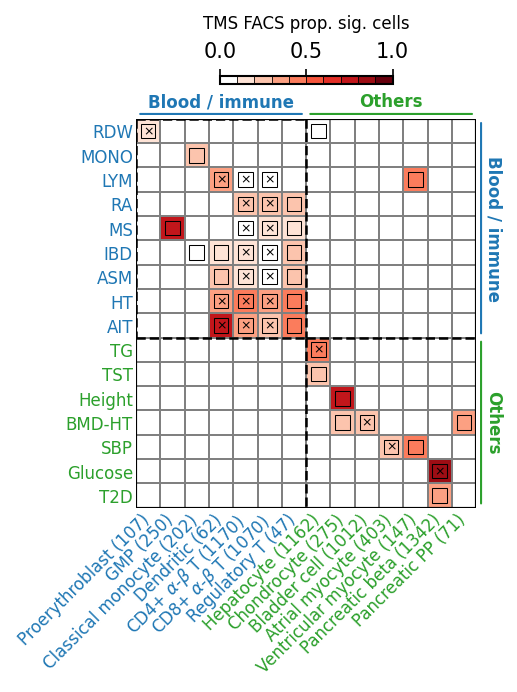

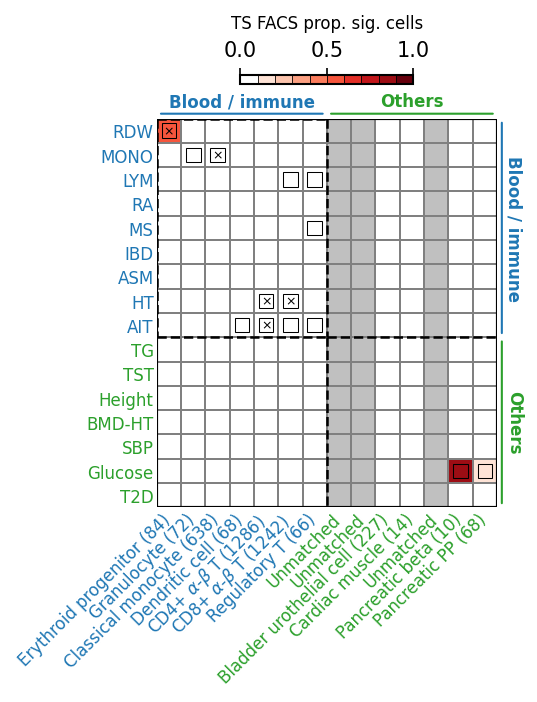

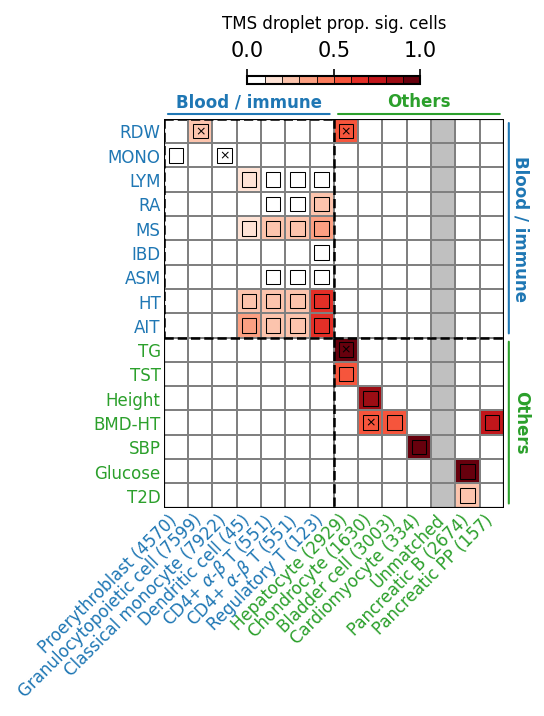

In [10]:
for dset in ["tms_facs", "ts_facs", "tms_droplet"]:
    fig, ax = plot_heatmap2(
        dataset=dset,
        trait_list=compare_trait_list,
        ct_list=dict_ct_list[dset],
        dict_x_seps={
            "Blood / immune": (9, "C0"),
            "Others": (7, "C2"),
        },  # traits
        dict_y_seps={
            "Blood / immune": (7, "C0"),
            "Others": (7, "C2"),
        },  # cell-types
    )
    plt.savefig(f"results/ct_assoc_contrast_heatmap_{dset}.pdf", bbox_inches="tight")

# Comparison using scatter plot / venn's diagram 

In [11]:
dict_ct_assoc_fdr = {
    dset: pd.DataFrame(
        multipletests(
            dict_ct_assoc[dset].fillna(0.5).values.flatten(), method="fdr_bh"
        )[1].reshape(dict_ct_assoc[dset].shape),
        index=dict_ct_assoc[dset].index,
        columns=dict_ct_assoc[dset].columns,
    )
    for dset in dict_ct_assoc
}


def venn_diagram(mask1, mask2, labels=["label1", "label2"]):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib_venn import venn2, venn2_circles
    from scipy.stats import fisher_exact

    plt.figure(figsize=(6, 3))

    assert len(mask1) == len(mask2)
    index1 = np.where(mask1)[0]
    index2 = np.where(mask2)[0]
    v = venn2([set(index1), set(index2)], set_labels=labels)
    c = venn2_circles([set(index1), set(index2)])

    contingency_tbl = np.zeros((2, 2))

    contingency_tbl[1, 0] = len(set(index1) - set(index2))
    contingency_tbl[0, 1] = len(set(index2) - set(index1))
    contingency_tbl[1, 1] = len(set(index1) & set(index2))
    contingency_tbl[0, 0] = (
        len(mask1)
        - contingency_tbl[1, 0]
        - contingency_tbl[0, 1]
        - contingency_tbl[1, 1]
    )
    print(fisher_exact(contingency_tbl))
    print(contingency_tbl)

In [12]:
from scipy.stats import spearmanr, pearsonr

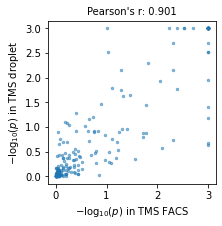

(188.57142857142858, 1.669698114125473e-26)
[[165.   4.]
 [  7.  32.]]


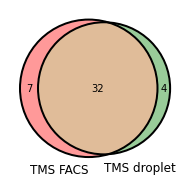

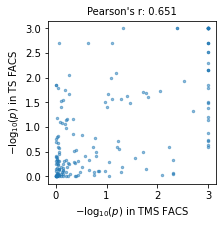

(22.159420289855074, 7.544796198434837e-07)
[[139.   3.]
 [ 23.  11.]]


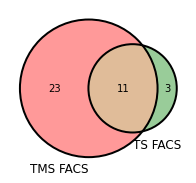

In [13]:
for dset_against in ["tms_droplet", "ts_facs"]:
    df_corres_ct = df_ct_list[["tms_facs", dset_against]].dropna()
    # scatter plot
    plt.figure(figsize=(3, 3))
    xs = -np.log10(
        dict_ct_assoc["tms_facs"]
        .loc[compare_trait_list, df_corres_ct["tms_facs"]]
        .values.flatten()
    )
    ys = -np.log10(
        dict_ct_assoc[dset_against]
        .loc[compare_trait_list, df_corres_ct[dset_against]]
        .values.flatten()
    )
    plt.scatter(
        xs,
        ys,
        s=6,
        alpha=0.5,
    )
    if dset_against == "ts_facs":

        display_name = "TS FACS"
    else:
        display_name = "TMS droplet"

    plt.xlabel("$-\log_{10}(p)$ in TMS FACS")
    plt.ylabel("$-\log_{10}(p)$ in" + f" {display_name}")
    cor = pearsonr(xs, ys)[0]
    plt.title(f"Pearson's r: {cor:.3g}", fontsize=10)

    plt.savefig(
        f"results/ct_assoc_contrast_scatter_{dset_against}.pdf", bbox_inches="tight"
    )
    plt.show()

    # Venn diagram
    venn_diagram(
        mask1=dict_ct_assoc_fdr["tms_facs"]
        .loc[compare_trait_list, df_corres_ct["tms_facs"]]
        .values.flatten()
        < 0.05,
        mask2=dict_ct_assoc_fdr[dset_against]
        .loc[compare_trait_list, df_corres_ct[dset_against]]
        .values.flatten()
        < 0.05,
        labels=["TMS FACS", display_name],
    )

    plt.savefig(
        f"results/ct_assoc_contrast_venn_{dset_against}.pdf", bbox_inches="tight"
    )